In [58]:
import pandas as pd
from my_pysyncon import Dataprep, Synth, AugSynth

In [59]:
df_mo = pd.read_csv('../../../Dataset_Generation/Jared/Data/total_state_data.csv')
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']

df_yr = pd.read_csv('../../../Dataset_Generation/Jared/Data/yearly_total_data.csv')
df_yr['co2_per_capita'] = df_yr['total_co2'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['yearly_energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['yearly_energy_flow'] / df_yr['yearly_population']

In [60]:
# set number of months to skip at a time when training monthly model.
# month_jumps = 1 means consider all monthly data; month_jumps = 12 means consider one month per year
month_jumps = 4

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]

# these are the dates used for our monthly graph
years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [61]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of cap-and-trade program (CA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", "OR", "PA", 
    #"RI", 
    "SC", "SD", "TN", "TX", "UT", 
    #"VT", 
    #"VA", 
    "WA", "WV", "WI", "WY"
    ]

In [62]:
# we create a synthetic control Delaware as applied to monthly data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_per_capita_range, "mean"),
        ('eflow_per_capita', preintervention_per_capita_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
)

In [63]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=['yearly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=range(1990,2010),
    special_predictors=[
        ('eprod_per_capita', range(1990,2010), "mean"),
        ('eflow_per_capita', range(1990,2010), "mean"),
        ('gdp_per_capita', range(1997,2010), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2010)
)

print(dataprep_yr)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990 - 2024
Time range for loss minimization: range(1990, 2010)
Time range for predictors: range(1990, 2010)
Predictors: yearly_num_plants
Special predictors:
    `eprod_per_capita` over `range(1990, 2010)` using `mean`
    `eflow_per_capita` over `range(1990, 2010)` using `mean`
    `gdp_per_capita` over `range(1997, 2010)` using `mean`




We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [64]:
# monthly version

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))

ID    0.152
MN    0.080
NV    0.621
SD    0.146
Name: weights, dtype: float64


In [65]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr)
print(synth_yr.weights(threshold=.01))

NV    0.718
WA    0.282
Name: weights, dtype: float64


In [66]:
years
treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

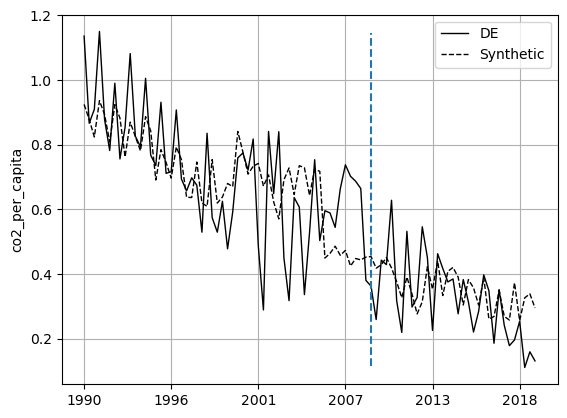

In [67]:
# Monthly synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])

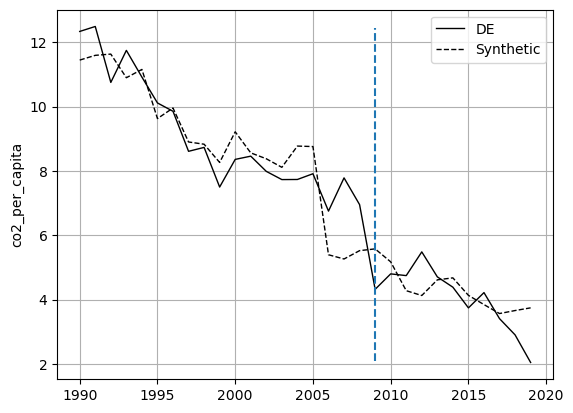

In [ ]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [69]:
synth_mo.summary()

,V,treated,synthetic,sample mean
monthly_num_plants,0.259,8.167,8.296,21.498
special.1.eprod_per_capita,0.332,0.000,0.002,0.062
special.2.eflow_per_capita,0.408,-0.030,-0.023,0.029
special.3.gdp_per_capita,0.000,0.006,0.004,0.004


In [70]:
synth_yr.summary()

,V,treated,synthetic,sample mean
yearly_num_plants,0.258,6.923,8.179,20.667
special.1.eprod_per_capita,0.347,0.003,0.034,0.754
special.2.eflow_per_capita,0.390,-0.355,-0.253,0.365
special.3.gdp_per_capita,0.006,0.078,0.057,0.046


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

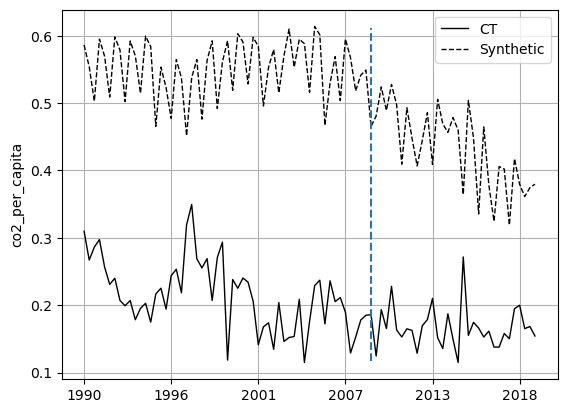

State: CT 

AZ    0.159
CO    0.016
FL    0.170
ID    0.023
IL    0.015
MI    0.050
MO    0.040
NV    0.094
NC    0.061
OR    0.166
SD    0.053
TN    0.010
WA    0.106
WI    0.025
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.548    0.005      0.006        0.062
special.2.eflow_per_capita  0.452   -0.015     -0.017        0.029
special.3.gdp_per_capita    0.000    0.006      0.004        0.004


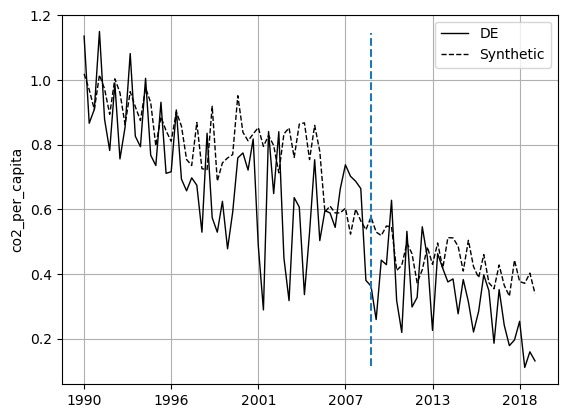

State: DE 

MN    0.421
NV    0.578
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.468    0.000      0.002        0.062
special.2.eflow_per_capita  0.532   -0.030     -0.024        0.029
special.3.gdp_per_capita    0.000    0.006      0.005        0.004


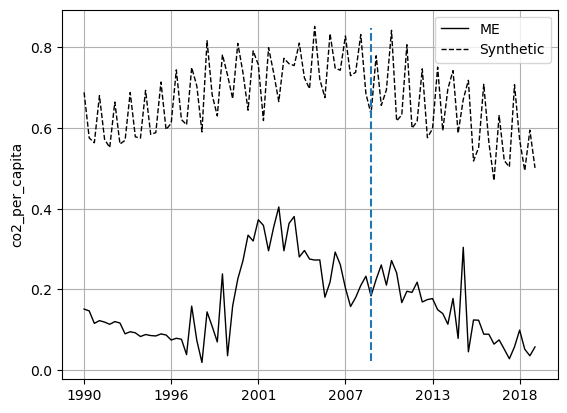

State: ME 

AL    0.022
AZ    0.031
AR    0.098
FL    0.039
GA    0.026
ID    0.108
IN    0.026
IA    0.033
MI    0.033
MN    0.021
MS    0.178
MO    0.037
NE    0.024
NV    0.020
NC    0.031
OH    0.027
OK    0.028
OR    0.040
PA    0.014
SC    0.035
SD    0.035
TN    0.035
WA    0.016
WI    0.034
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.367    0.010      0.010        0.062
special.2.eflow_per_capita  0.000   -0.018     -0.019        0.029
special.3.gdp_per_capita    0.633    0.004      0.004        0.004


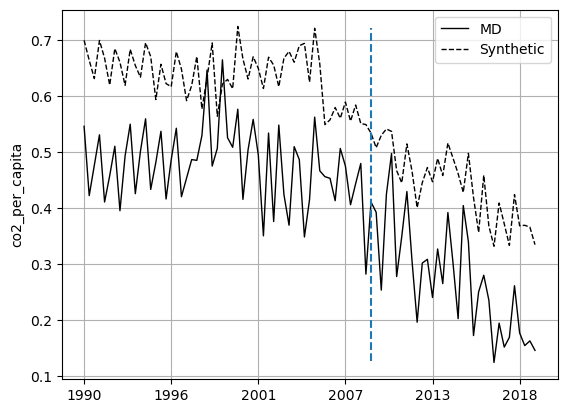

State: MD 

FL    0.027
GA    0.019
ID    0.015
IL    0.173
IA    0.018
MI    0.015
MN    0.167
MO    0.032
NV    0.260
NC    0.020
OR    0.017
SD    0.017
TN    0.012
WA    0.164
WI    0.027
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.776    0.004      0.006        0.062
special.2.eflow_per_capita  0.000   -0.018     -0.020        0.029
special.3.gdp_per_capita    0.224    0.004      0.004        0.004


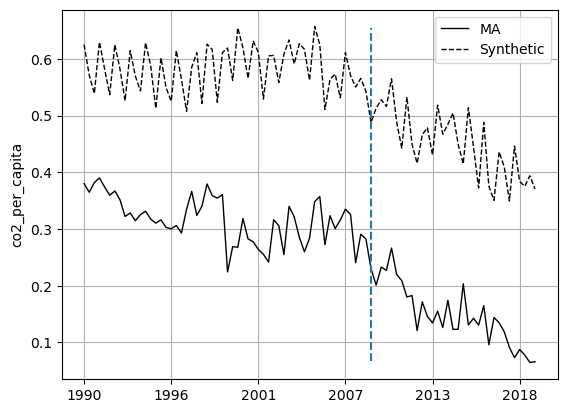

State: MA 

AZ    0.074
FL    0.140
GA    0.035
ID    0.055
MI    0.056
MN    0.049
MO    0.082
NV    0.118
NC    0.067
OR    0.122
SD    0.062
WA    0.071
WI    0.064
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.554    0.001      0.004        0.062
special.2.eflow_per_capita  0.446   -0.018     -0.020        0.029
special.3.gdp_per_capita    0.000    0.005      0.004        0.004


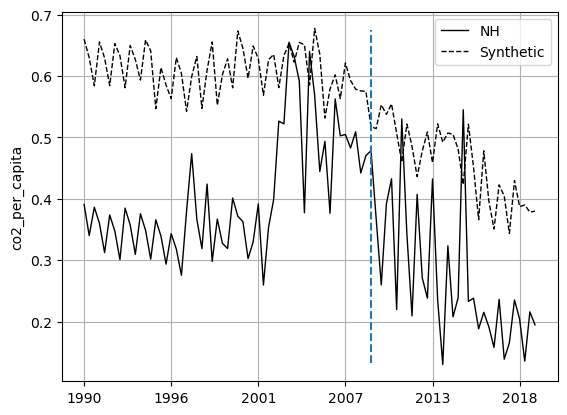

State: NH 

AZ    0.080
CO    0.079
FL    0.077
GA    0.011
ID    0.041
IL    0.105
MI    0.032
MN    0.070
MO    0.024
NV    0.138
NC    0.032
OR    0.081
PA    0.024
SD    0.034
UT    0.029
WA    0.117
WI    0.018
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.352    0.008      0.010        0.062
special.2.eflow_per_capita  0.294   -0.012     -0.014        0.029
special.3.gdp_per_capita    0.354    0.004      0.004        0.004


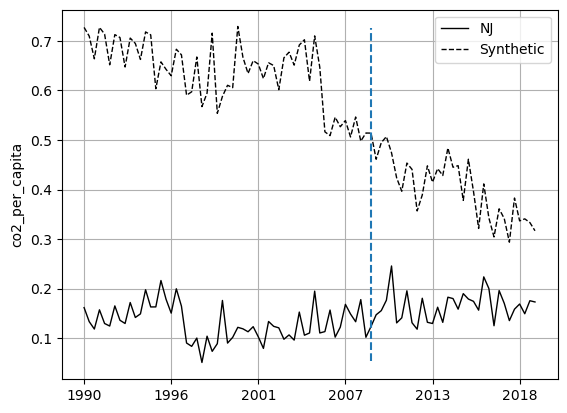

State: NJ 

IL    0.220
MN    0.228
NV    0.356
WA    0.197
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.418    0.003      0.006        0.062
special.2.eflow_per_capita  0.579   -0.022     -0.020        0.029
special.3.gdp_per_capita    0.003    0.005      0.005        0.004


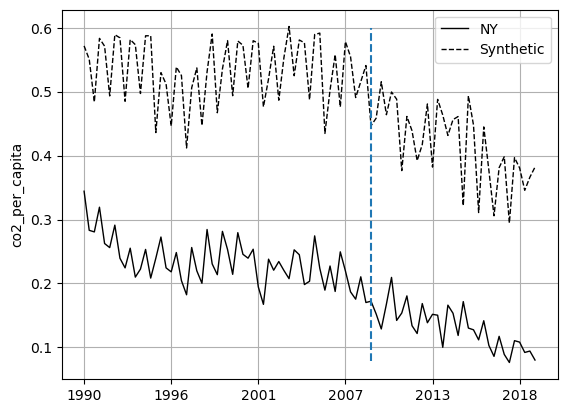

State: NY 

AZ    0.200
FL    0.217
MI    0.037
MO    0.022
NV    0.100
NC    0.053
OR    0.211
SD    0.042
WA    0.118
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.596    0.003      0.005        0.062
special.2.eflow_per_capita  0.404   -0.014     -0.016        0.029
special.3.gdp_per_capita    0.000    0.005      0.004        0.004


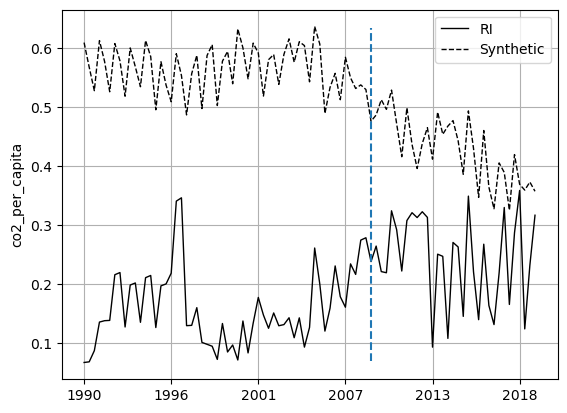

State: RI 

AZ    0.088
FL    0.120
GA    0.034
ID    0.054
IL    0.042
MI    0.047
MN    0.064
MO    0.054
NV    0.135
NC    0.052
OR    0.114
SD    0.051
WA    0.105
WI    0.041
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.237    0.000      0.005        0.062
special.2.eflow_per_capita  0.414   -0.017     -0.019        0.029
special.3.gdp_per_capita    0.349    0.004      0.004        0.004


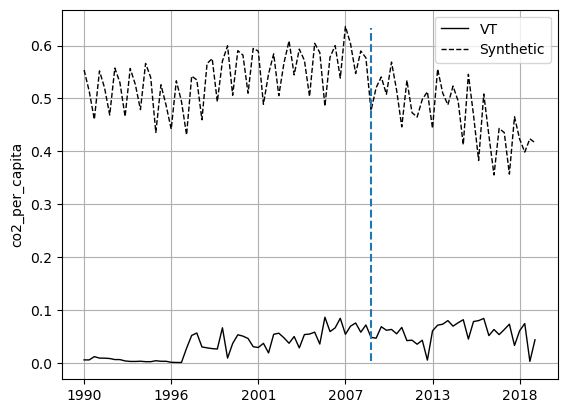

State: VT 

AZ    0.192
AR    0.028
FL    0.181
ID    0.142
MI    0.043
MS    0.036
MO    0.017
NC    0.033
OR    0.205
PA    0.012
SD    0.055
UT    0.041
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.330    0.008      0.010        0.062
special.2.eflow_per_capita  0.329   -0.012     -0.014        0.029
special.3.gdp_per_capita    0.342    0.004      0.004        0.004


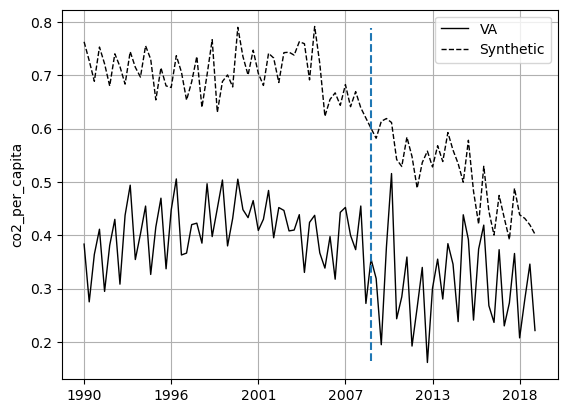

State: VA 

CO    0.113
GA    0.039
IL    0.193
LA    0.012
MN    0.154
NE    0.021
NV    0.219
WA    0.162
Name: weights, dtype: float64 

                                V  treated  synthetic  sample mean
special.1.eprod_per_capita  0.381    0.016      0.016        0.062
special.2.eflow_per_capita  0.465   -0.011     -0.011        0.029
special.3.gdp_per_capita    0.154    0.005      0.005        0.004


In [71]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:
    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=[], 
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_per_capita_range, "mean"),
        ('eflow_per_capita', preintervention_per_capita_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # monthly version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])

    print('State:', state,'\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    